# NLP Assignment - 1

## Group - 29

Description of Data: IMDB dataset having 50K movie reviews for natural language processing or Text analytics.

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

Link to the dataset - https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/download

### Approach

## Library imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
sp = spacy.load('en_core_web_sm')
import spacy
from spacy import displacy
from wordcloud import WordCloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import warnings
warnings.simplefilter("ignore")

## Load the dataset and validate the data load

In [2]:
reviews = pd.read_csv("D:/LargeDatasets/IMDBDataset.csv")

# Check oon the few rows
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Check on the distribution of the sentiment variable

positive    25000
negative    25000
Name: sentiment, dtype: int64


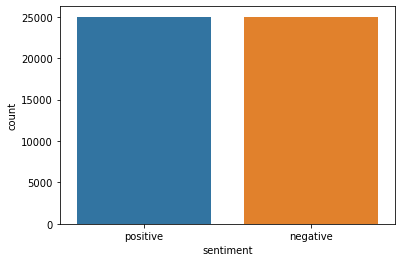

In [3]:
sns.countplot(x='sentiment', data=reviews)
print(reviews['sentiment'].value_counts())

We have a balanced distribution between positive and negative reviews in the dataset

In [4]:
# Check for any missing values
reviews.isna().sum()

review       0
sentiment    0
dtype: int64

There are no missing values in the data

#### Let us examine one positive and one negative review

In [5]:
# Let us go through a positive review
reviews[reviews['sentiment'] == 'positive']['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
# Let us go through a negative review
reviews[reviews['sentiment'] == 'negative']['review'].iloc[0]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

## Data Preparation
## Text Analytics and Text Cleanup

#### Remove Punctuations and some html chacracters using regular expressions

In [7]:
# Html characters and some symbols removal
reviews['review'] = reviews['review'].apply(lambda s : re.sub(r'<br />', '', s))

# Removing punctuations using Regex
reviews['review'] = reviews['review'].apply(lambda s : re.sub(r'[^\w\s]','', s))

#### Convert every review text words to lower case

In [8]:
# Conversion to Lower case

reviews['review'] = reviews['review'].str.lower()

In [9]:
# verify the reviews column now

reviews['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

#### Display POS Tagging for the first 4 reviews

In [10]:
# Display
for reviewText in reviews['review'][:4]:
    print("\n")
    print(f"Review Text - {reviewText}")
    reviewText = sp(reviewText)
    for ent in reviewText:
        print("------------------------------------------------------------------------")
        print(f'{ent.text:{10}} {ent.pos_:{8}} {ent.tag_:{8}} {spacy.explain(ent.tag_)}')
        #print(ent, ent.pos_)

---------------
career     NOUN     NN       noun, singular or mass
------------------------------------------------------------------------
but        CCONJ    CC       conjunction, coordinating
------------------------------------------------------------------------
it         PRON     PRP      pronoun, personal
------------------------------------------------------------------------
was        AUX      VBD      verb, past tense
------------------------------------------------------------------------
wittier    ADJ      JJR      adjective, comparative
------------------------------------------------------------------------
than       SCONJ    IN       conjunction, subordinating or preposition
------------------------------------------------------------------------
devil      NOUN     NN       noun, singular or mass
------------------------------------------------------------------------
wears      NOUN     NNS      noun, plural
--------------------------------------------------------

In [11]:
# We will remove the stopwords for every review in the column 
reviews['review'] = reviews['review'].apply(lambda x : ' '.join([word for word in x.split() if not word in sp.Defaults.stop_words]))

In [12]:
reviews['review'][:4]

0    reviewers mentioned watching 1 oz episode youl...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
Name: review, dtype: object

#### Build Word Clouds for both positive and negative reviews

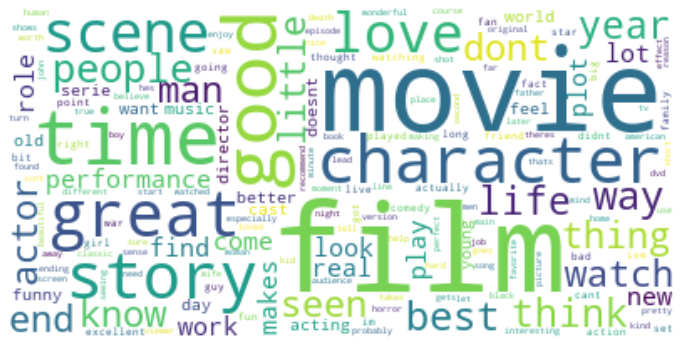

In [13]:
# We will display the word cloud for all positive reviews

text = " ".join(reviewtext for reviewtext in reviews[reviews['sentiment'] == 'positive']['review'])
word_cloud = WordCloud(collocations=False, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(12, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

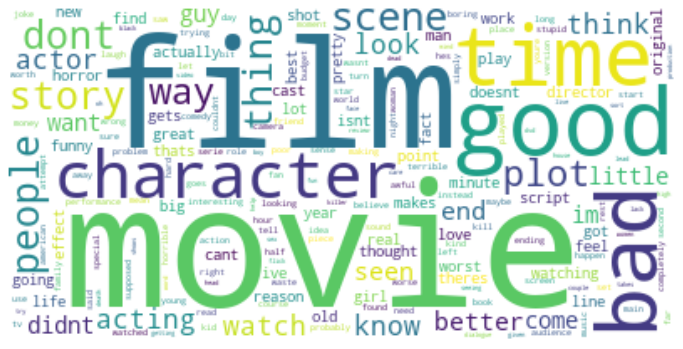

In [14]:
# We will display the word cloud for all negative reviews

text = " ".join(reviewtext for reviewtext in reviews[reviews['sentiment'] == 'negative']['review'])
word_cloud = WordCloud(collocations=False, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(12, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelling Preparation

### Label Encoding the target attribute 'sentiment'
### Peform the Train-Test Split

In [15]:
# Label encoding the target attribute 'sentiment'
encoder = LabelEncoder()
reviews['sentiment'] = encoder.fit_transform(reviews['sentiment'])

In [16]:
# Perform the train-test split

features = reviews['review']
target = reviews['sentiment']

# Perform the split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=101)

## Model Approach 1 - Sentiment Analysis using Multinomial NB and Support Vector Classifier

### We will develop a selection of pipeline, each with a different model

In each pipeline, TfidfVectorization will happen followed by the application of the specific modelling technique

In [17]:
# Build the pipeline

# Multinomial Naive Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()), 
                        ('clf', MultinomialNB())])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()), 
                          ('clf', LinearSVC())])

In [18]:
# Feed the training data through the pipelines

# Pipeline - multinomial Naive Bayes
text_clf_nb.fit(features_train, target_train)

# Pipeline - Linear Support Vector Classifier
text_clf_lsvc.fit(features_train, target_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [19]:
# Run the predictions for both the text classifiers

predictions_nb = text_clf_nb.predict(features_test)
predictions_lsvc = text_clf_lsvc.predict(features_test)

#### Model Performance - Multinomial Naive Bayes

In [20]:
print("Accuracy Score")
print(accuracy_score(target_test, predictions_nb))
print("\n")
print(classification_report(target_test, predictions_nb))
print("\n")
print(confusion_matrix(target_test, predictions_nb))
print("\n")
print(f1_score(target_test, predictions_nb))

Accuracy Score
0.8624


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7474
           1       0.87      0.85      0.86      7526

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



[[6528  946]
 [1118 6408]]


0.8612903225806452


#### Model Performance - Linear SVC

In [21]:
print("Accuracy Score")
print(accuracy_score(target_test, predictions_lsvc))
print("\n")
print(classification_report(target_test, predictions_lsvc))
print("\n")
print(confusion_matrix(target_test, predictions_lsvc))
print("\n")
print(f1_score(target_test, predictions_lsvc))

Accuracy Score
0.8923333333333333


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7474
           1       0.89      0.90      0.89      7526

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



[[6595  879]
 [ 736 6790]]


0.8937150378413953


## Model Approach 2 - Sentiment Analysis using VADER (Valence Aware Dictionary for Sentiment Reasoning)

In [22]:
sid = SentimentIntensityAnalyzer()

#### Use this intensity analyzer to append a compound score to the dataset

In [23]:
reviews['scores'] = reviews['review'].apply(lambda review: sid.polarity_scores(review))
reviews['compound'] = reviews['scores'].apply(lambda score_dict: score_dict['compound'])
reviews['comp_score'] = reviews['compound'].apply(lambda x: 1 if x >= 0 else 0)
reviews.head()

,review,sentiment,scores,compound,comp_score
0,reviewers mentioned watching 1 oz episode youl...,1,"{'neg': 0.331, 'neu': 0.567, 'pos': 0.102, 'co...",-0.9938,0
1,wonderful little production filming technique ...,1,"{'neg': 0.091, 'neu': 0.66, 'pos': 0.249, 'com...",0.9153,1
2,thought wonderful way spend time hot summer we...,1,"{'neg': 0.145, 'neu': 0.504, 'pos': 0.352, 'co...",0.9666,1
3,basically theres family little boy jake thinks...,0,"{'neg': 0.244, 'neu': 0.663, 'pos': 0.092, 'co...",-0.9286,0
4,petter matteis love time money visually stunni...,1,"{'neg': 0.034, 'neu': 0.682, 'pos': 0.284, 'co...",0.9871,1


In [24]:
print("Accuracy Score")
print(accuracy_score(reviews['sentiment'], reviews['comp_score']))
print("\n")
print(classification_report(reviews['sentiment'], reviews['comp_score']))
print("\n")
print(confusion_matrix(reviews['sentiment'], reviews['comp_score']))

Accuracy Score
0.67348


              precision    recall  f1-score   support

           0       0.77      0.49      0.60     25000
           1       0.63      0.86      0.72     25000

    accuracy                           0.67     50000
   macro avg       0.70      0.67      0.66     50000
weighted avg       0.70      0.67      0.66     50000



[[12290 12710]
 [ 3616 21384]]


## Model Approach 3 - Building a Neural Network Model

### Dependency Parser Tree for the sentence below

**“The Starks have now effectively lost all their power, and the surviving Stark children are scattered around the continent, either prisoners or in hiding."**

In [25]:
doc = sp(u"The Starks have now effectively lost all their power, and the surviving Stark children are scattered around the continent, either prisoners or in hiding.")

# Render the dependency parse immediately inside Jupyter:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 85})